Install the necessary libraries to your Python environment.  It is a best practice to create a virtual environment to run these samples.

In [ ]:
!pip install psycopg2
!pip install pgvector #https://github.com/pgvector/pgvector
!pip install transformers
!pip install azureml-sdk
!pip install scikit-image
!pip install azure-ai-translation-text

Import any modules, functions and classes.

In [ ]:
import psycopg2
from pgvector.psycopg2 import register_vector
import json
import skimage

TODO

In [ ]:
import urllib.request
import os
import json

from azure.core.credentials import AzureKeyCredential   
from azure.ai.translation.text import TextTranslationClient, TranslatorCredential
from azure.ai.translation.text.models import InputTextItem

filename = 'metadata.json'
translated_filename = 'metadata_translated.json'
translate_api_key  = '77f25d1126e24f1c99d0a7eab7161e1d'
translate_api_region = 'global'

#if you would like to start from scratch, run this function
def download_and_translate():
    #download the data...
    download_metadata('https://raw.githubusercontent.com/zalandoresearch/feidegger/master/data/FEIDEGGER_release_1.2.json')

    with open(filename) as json_file:
        data = json.load(json_file)

    #translate the data
    for item in data:
        descriptions = []
        for description in item['descriptions']:
            descriptions.append(translate(description, 'de', 'en'))
        item['descriptions'] = descriptions

    #save the translated data
    with open('metadata_translated.json', 'w') as outfile:
        json.dump(data, outfile)
    
def download_metadata(url):
    if not os.path.exists(filename):
        urllib.request.urlretrieve(url, filename)

def translate(text, source_language, target_language):
    try:
        text_translator = TextTranslationClient(credential = TranslatorCredential(translate_api_key, translate_api_region))
        input_text_elements = [ InputTextItem(text = text) ]
        response = text_translator.translate(content = input_text_elements, to = [target_language], from_parameter = source_language)
        translation = response[0] if response else None
        if translation:
            for translated_text in translation.translations:
                return translated_text.text
    except Exception as e:
        print(e)
            

In [ ]:
#download_and_translate()

with open(translated_filename) as json_file:
    data = json.load(json_file)

# Enable Extensions

- Browse to the Azure Portal
- Browse to the Azure Database for PostgreSQL Flexible Server
- Set the `azure.extensions` to enable `vector` and `azure_ai` and `azure_storage`
- Select **Save**

The following code will create a connection to the server and then register pgvector.

In [ ]:
dbhost = 'pgsqldevilkdittaflex16.postgres.database.azure.com'
dbport = '5432'
dbuser = 'wsuser'
dbpass = 'Solliance123'
#dbpass = 'Seattle123Seattle123'
dbname = 'products'

dbconn = psycopg2.connect(host=dbhost, user=dbuser, password=dbpass,
    port=dbport, database=dbname , connect_timeout=10)
dbconn.set_session(autocommit=True)

register_vector(dbconn)

In [ ]:
#https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2
def encode_sentence(sentences):
    from sentence_transformers import SentenceTransformer
    model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
    embeddings = model.encode(sentences)
    return embeddings

In [ ]:
def generate_embeddings(data):
    r = {}
    r['url'] = data['url']
    r['descriptions'] = data['descriptions']
    r['split'] = data['split']
    vector = encode_sentence(data['descriptions'])
    r['descriptions_embeddings'] = vector
    return r

In [ ]:
#This will take ~8-10mins to execute...
cur = dbconn.cursor()
cur.execute("CREATE EXTENSION IF NOT EXISTS vector;")
cur.execute("DROP TABLE IF EXISTS products;")
cur.execute("""CREATE TABLE IF NOT EXISTS products(
  id bigserial primary key,
  description text,
  url text,
  split int,
  descriptions_embeddings vector(384)
);""")

In [ ]:
#take top 100 for now...
top_100_data = data[:250]

for x in top_100_data:
    r = generate_embeddings(x)
    cur.execute("INSERT INTO products (url, description, split, descriptions_embeddings) VALUES (%s, %s, %s, %s)", (r['url'], r['descriptions'][0], r['split'], r['descriptions_embeddings'][0]))
    
#for x in data:
#    cur.execute("""INSERT INTO products (description, url, split, descriptions_embeddings)
#	  VALUES (%s, %s, %s, %s);""",
#	  (' '.join(x.get('descriptions', [])), x.get('url'), x.get('split'), x.get('descriptions_embeddings') ))

cur.execute("""CREATE INDEX ON products
  USING ivfflat (descriptions_embeddings vector_l2_ops) WITH (lists = 100);""")
cur.execute("VACUUM ANALYZE products;")
cur.close()

In [ ]:
import numpy as np
from skimage import io
import matplotlib.pyplot as plt
import requests

cur = dbconn.cursor()

result = encode_sentence("red sleeveless summer wear")

cur.execute("""SELECT id, url, description, descriptions_embeddings
  FROM products
  ORDER BY descriptions_embeddings <-> %s limit 2;""",
  (np.array(result),))

r = cur.fetchall()
urls = []
plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True

for x in r:
    url = x[1].split('?')[0]
    urldata = requests.get(url).content
    print("Product Item Id: " + str(x[0]))
    a = io.imread(url)
    plt.imshow(a)
    plt.axis('off')
    plt.show()

cur.close()

# Azure AI Studio

In addition to using the built in transformers via Python, you can also call models that are deployed in Azure.  In this example you will deploy an AI model in Azure Machine Learning and then call it from python. Note that this model is a text generation model and not an embedding model.

## Create Workspace

- Open the Azure Portal
- Search for **Azure Machine Learning Studio**
- On the **Overview** page, select the **Studio web URL** link
- Select the **TODO** project
- Select **Workspaces**
- Select **New**
- Enter in all the fields
- Select **Model catalog**
- Select the **gpt2** model
- Select **Deploy**
- Enter the following:
  - Template **transformaer-cpu-small**
  - Virtual Machien **Standard_DS2_v2**
  - Instance count **2**
- Select **Deploy**, it may take a couple minutes for the deployment to complete. You will know the deployment is complete with the **Provisioning state** changes to **Succeeded**
- Select the **Consume** tab
- Copy the **REST endpoint** and **primary key**
- Run the following cells

In [ ]:
#Enter your API URL and API Key here
uri = 'YOUR_API_URL'
api_key = 'YOUR_API_KEY'

In [ ]:
import requests
import json

#set the sentance  to embed
data= {"inputs": "red sleeveless summer wear"}

res = requests.post(uri, headers={'Content-Type':'application/json', 'Authorization':('Bearer '+ api_key)}, json=data).json()

print(res)

Now that you have deployed a simple model via Azure Machine Learning Studio, let's look at redo-ing our embeddings using a much more performant embedding model called `text-embedding-ada-002`.

This model is not deploying via Azure Machine Learning Studio, but is a part of Azure OpenAI.

- Open the Azure Portal
- Search for **Azure AI Studio**
- Select the **TODO** project
- One the **Overview** page, select the **Studio web URL** link
- Select **Model catalog**
- Search for **embeddings**
- Select the **text-embedding-ada-002** model
- Notice the model is deployed via Azure Open AI

    > NOTE: If you want to manually create the model and deployment, select the **embeddings** link at the bottom of the page.  Select **Continue** to be taken to the Azure OpenAI Studio.

- Select **Deploy**, if you have an Azure Open AI instance, the dialog will select it for you
- For the deployment name, type **embeddings**
- Select **Deploy**
- Once the model is deployed, run the following cells to regenerate your embeddings

In [ ]:
from langchain.embeddings.openai import OpenAIEmbeddings

#get the openai embeddings
embedding_model = "embeddings" #this is the name of the model deployment in azure open ai (not the type of model)
azure_endpoint = "YOUR_API_URL"  #https://fllm4693d-openai.openai.azure.com/
azure_key = 'YOUR_API_KEY'  #abcdf0a8efa1432796a3dab8f0e61234

embeddings = OpenAIEmbeddings(
                deployment=embedding_model,
                openai_api_base=azure_endpoint,
                openai_api_key=azure_key,
                openai_api_type="azure",
            )

In [ ]:
def encode_openai_sentence(sentence):
    return embeddings.embed_documents([sentence])[0]

def encode_openai_sentences(sentences):
    return embeddings.embed_documents(sentences)

def generate_openai_embeddings(data):
    r = {}
    r['url'] = data['url']
    r['descriptions'] = data['descriptions']
    r['split'] = data['split']
    vector = encode_openai_sentences(data['descriptions'])
    r['descriptions_embeddings'] = vector
    return r

In [40]:
#reset the embeddings table to 1536 dimensions (the hugging face model was only 384)
cur = dbconn.cursor()
cur.execute("CREATE EXTENSION IF NOT EXISTS vector;")
cur.execute("DROP TABLE IF EXISTS products;")
cur.execute("""CREATE TABLE IF NOT EXISTS products(
  id bigserial primary key,
  description text,
  url text,
  split int,
  descriptions_embeddings vector(1536)
);""")

In [44]:
#take top 100 for now...
top_100_data = data[:250]

#query the database
cur = dbconn.cursor()

for x in top_100_data:
    r = generate_openai_embeddings(x)
    cur.execute("INSERT INTO products (url, description, split, descriptions_embeddings) VALUES (%s, %s, %s, %s)", (r['url'], r['descriptions'][0], r['split'], r['descriptions_embeddings'][0]))

cur.close()

Product Item Id: 222


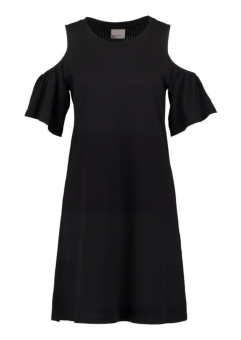

Product Item Id: 207


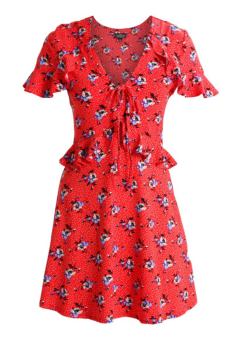

In [45]:
#encode the sentence
result = encode_openai_sentence("red sleeveless summer wear")

cur = dbconn.cursor()

#do a search...
cur.execute("""SELECT id, url, description, descriptions_embeddings
  FROM products
  ORDER BY descriptions_embeddings <-> %s limit 2;""",
  (np.array(result),))

r = cur.fetchall()
urls = []
plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True

for x in r:
    url = x[1].split('?')[0]
    urldata = requests.get(url).content
    print("Product Item Id: " + str(x[0]))
    a = io.imread(url)
    plt.imshow(a)
    plt.axis('off')
    plt.show()

cur.close()